# Modelling dam volumes using DEA waterbodies

**Products used:** 
[DE Africa Waterbodies](https://docs.digitalearthafrica.org/en/latest/data_specs/Waterbodies_specs.html), 
[Department of Water Affairs and Sanitation, South Africa Dam Level and Volume Data](https://www.dws.gov.za/Hydrology/Verified/hymain.aspx)

# Section 3 : *Model Prediction and Error Evaluation*

## Background

### Digital Twin (DT)
The CGIAR Digital Twin initiative creates dynamic virtual models that combine real-time data, AI, and simulations to improve decision-making. Its prototype for the Limpopo River Basin focuses on enhancing water resource management and conservation.


## Description
This notebook presents a workflow for predicting dam levels and volumes using water surface area data from DE Africa's Waterbodies product, integrating data preprocessing, feature extraction, and Gradient Boosting modeling. 

As part of the CGIAR Initiative on Digital Innovation, this work contributes to a prototype Digital Twin for the Limpopo River Basin, designed to support real-time decision-making in water management. The Digital Twin leverages AI-driven tools to visualize and simulate the impact of decisions on the basin's ecosystem. To enhance prediction reliability, the model includes a correction mechanism to address unrealistic large drops in dam volume estimates.


## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
import xarray as xr
import seaborn as sns
import datacube
import joblib
import pickle

from scipy import interpolate
from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor

import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
import plotly.graph_objects as go

from deafrica_tools.waterbodies import get_waterbody, get_time_series, display_time_series
from IPython.display import Image


## Loading data

This dataset contains raw water levels data collected from DEA (Department of Environmental Affairs) in South Africa. The cell below reads this ancillary data necessary to conduct the volume prediction.

In [2]:
rating_curve = pd.read_csv('data/DWS/rating_curve.csv')
daily_volumes = pd.read_csv('data/DWS/daily_volumes.csv')
dam_attributes = pd.read_csv('data/dam_attributes/dam_attributes.csv')

#### Convert date columns to datetime

In [3]:
daily_volumes = daily_volumes.copy()
daily_volumes['Date'] = pd.to_datetime(daily_volumes['Date'])

In [4]:
full_volume = dam_attributes[dam_attributes['parameter'] == 'full_volume']['value'].values[0]
full_surface_area = dam_attributes[dam_attributes['parameter'] == 'full_surface_area']['value'].values[0]
full_dam_level = dam_attributes[dam_attributes['parameter'] == 'full_dam_level']['value'].values[0]
maximum_dam_level = dam_attributes[dam_attributes['parameter'] == 'maximum_dam_level']['value'].values[0]
capacity_of_spillway = dam_attributes[dam_attributes['parameter'] == 'capacity_of_spillway']['value'].values[0]
vertical_drop = dam_attributes[dam_attributes['parameter'] == 'vertical_drop']['value'].values[0]
mean_depth = dam_attributes[dam_attributes['parameter'] == 'mean_depth']['value'].values[0]
full_capacity_elevation = dam_attributes[dam_attributes['parameter'] == 'full_capacity_elevation']['value'].values[0]
shoreline_length = dam_attributes[dam_attributes['parameter'] == 'shoreline_length']['value'].values[0]
maximum_volume = dam_attributes[dam_attributes['parameter'] == 'maximum_volume']['value'].values[0]
maximum_surface_area = dam_attributes[dam_attributes['parameter'] == 'maximum_surface_area']['value'].values[0]

In [5]:
original_count = len(daily_volumes)
trimmed_observed = daily_volumes[daily_volumes['Volume_mcm'] <= maximum_volume]
trimmed_count = len(trimmed_observed)
removed_samples = original_count - trimmed_count
print(f"Number of samples removed: {removed_samples}")
print(f"Valid number of samples: {original_count - removed_samples}")


Number of samples removed: 16
Valid number of samples: 8299


# Predict Dam Levels and Convert to Volumes Using the Rating Curve

After training the Gradient Boosting Regressor model, the next step is to predict the **dam levels** for the entire dataset and convert both the predicted and observed dam levels into corresponding **water volumes** using the **rating curve**.

Once the model is trained, we use it to predict the dam levels based on the input features (`calculated_level` and `water_area_ha`). The predicted dam levels are stored in `y_pred_full`:


In [6]:
features_imputed_df = pd.read_csv("data/prediction_data.csv")
target = pd.read_csv("data/test_data.csv")
merged_data = pd.read_csv("data/preprocess_data.csv")
merged_data['Date']= pd.to_datetime(merged_data['Date'])

target = pd.DataFrame(target, columns=['Dam_Level'])
target = target['Dam_Level']
y_pred_full = features_imputed_df['0']

#### Plot observed vs predicted levels over time

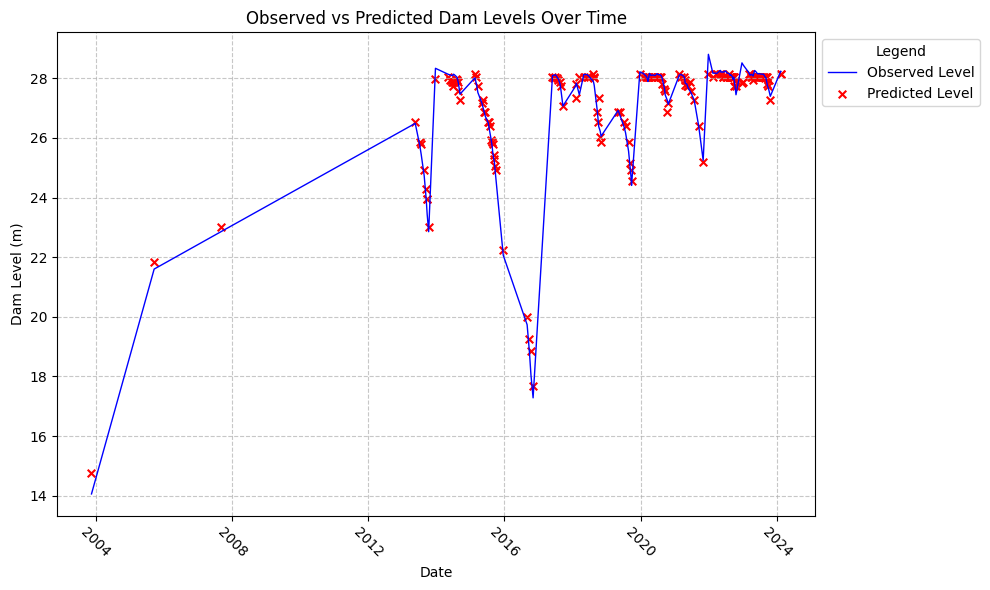

In [7]:
# Create the dataframes
observed_levels_df = pd.DataFrame({
    'Date': merged_data['Date'],
    'Observed Level': merged_data['Dam_Level']
})

predicted_levels_df = pd.DataFrame({
    'Date': merged_data['Date'],
    'Predicted Level': y_pred_full
})

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Observed Level
ax.plot(observed_levels_df['Date'], observed_levels_df['Observed Level'], 
        label='Observed Level', color='blue', linewidth=1)

# Plot Predicted Level (using scatter for markers)
ax.scatter(predicted_levels_df['Date'], predicted_levels_df['Predicted Level'], 
           label='Predicted Level', color='red', marker='x', s=30)

# Set title and labels
ax.set_title('Observed vs Predicted Dam Levels Over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Dam Level (m)')
plt.xticks(rotation=-45)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(title='Legend', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

# Save the figure as a PNG image
# image_path = "observed_vs_predicted_dam_levels_matplotlib.png"
# plt.savefig(image_path, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


#### Evaluate the performance of the predicted levels vs. observed levels against entire dataset

In [8]:
mse_full = mean_squared_error(target, y_pred_full)
rmse_full = np.sqrt(mse_full)

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_full = mean_absolute_percentage_error(target, y_pred_full)
r2_full = r2_score(target, y_pred_full)
print(f"{'RMSE':<10} {'MAPE':<10} {'R² Score':<10}")
print(f"{rmse_full:<10.4f} {mape_full:<10.2f} {r2_full:<10.4f}")

RMSE       MAPE       R² Score  
0.2220     0.62       0.9897    


### Prediction Refinement

#### Dam level volume interpolation

Next, we use the rating curve to map the **dam levels** to **volumes**. The rating curve provides a relationship between **dam level** and **volume** for the reservoir, and we use interpolation to make this mapping. The `interpolate.interp1d` function is used to create a mapping from dam levels to volumes:

In [9]:
rating_curve_interp_volume = interpolate.interp1d(rating_curve['water_level'], rating_curve['volume_mcm'], fill_value="extrapolate")

This interpolation allows us to take both the observed dam levels (target.values) and the predicted dam levels (y_pred_full) and convert them into volumes using the rating curve:

In [10]:
observed_volumes_full = rating_curve_interp_volume(target.values)
predicted_volumes_full = rating_curve_interp_volume(y_pred_full)

#### Calculate Maximum Percentage Drop Between Consecutive Actual Volume Readings

##### Why We Do This:
- **Identify Realistic Drops**: By calculating the maximum percentage drop between consecutive readings, we can identify what levels of volume depletion are realistically expected. This helps distinguish between normal variations and extreme cases.
  
- **Model Correction**: If the model drastically under-predicts volumes (for example, when predicted volumes show unrealistically large drops), this analysis allows us to apply corrections. By identifying the normal range of percentage drops, we can use this information to adjust the model predictions and prevent unrealistic under-predictions.

- **Improve Prediction Accuracy**: Understanding typical percentage drops between readings enables us to refine the model. If predicted drops fall outside of expected ranges, corrective actions can be taken, ensuring that model outputs better match observed patterns.

- The percentage drop between consecutive actual readings is calculated by comparing the current volume with the previous volume. The formula used is:

$$
\text{percentDrop} = \frac{(\text{previous}_{volume} - \text{current}_{volume})}{\text{previous}_{volume}} \times 100
$$


- This calculates how much the volume has decreased as a percentage of the previous volume

This step is crucial to maintain the reliability of model outputs and ensure that predicted water volumes remain realistic based on historical trends and known behavior of water depletion in the dam.

In [11]:
daily_volumes = daily_volumes.sort_values(by='Date')
daily_volumes['previous_volume'] = daily_volumes['Volume_mcm'].shift(1)
daily_volumes['percent_drop'] = (daily_volumes['previous_volume'] - daily_volumes['Volume_mcm']) / daily_volumes['previous_volume'] * 100
max_percent_drop = daily_volumes['percent_drop'].max()
print(f"Max Percent Drop between actual readings: {max_percent_drop}%")

Max Percent Drop between actual readings: 4.11120333501487%


#### Creating Predicted Data and Applying the Maximum Percent Drop Rule

In this section, we first create the `predicted_data` DataFrame, which stores the predicted dam volumes along with their corresponding dates. The predicted volumes are derived from earlier model outputs based on observed water levels. 

The main purpose of this step is to apply a validation rule known as the **maximum percent drop rule**. This rule ensures that the predicted volumes do not show unrealistic, sharp declines between consecutive data points, especially when there are large time gaps between observations. By comparing the predicted dam volume at each time step with the previous one, the rule checks if the drop in volume exceeds the maximum percentage drop observed historically. If the actual drop exceeds this threshold, the predicted volume is adjusted to fall within reasonable limits.

To account for varying time gaps between readings, the **median time difference** between consecutive observations is calculated and used to apply the rule only when the time difference between consecutive readings is smaller than or equal to this median. This helps ensure that the predicted dam volumes are consistent with the natural behavior of water level changes over time, particularly in cases where data points are sparse and sporadic.

Finally, the rule is applied to the `predicted_data`, correcting any instances where the predicted drop in volume is considered unrealistic, maintaining the integrity and accuracy of the predictions.


In [12]:
predicted_data = pd.DataFrame({
    'date': merged_data['Date'],
    'Predicted_Dam_Volume': predicted_volumes_full
})

def apply_max_percent_drop_rule(data, max_percent_drop, median_time_diff):
    data = data.sort_values(by='date')
    
    for i in range(1, len(data)):
        prev_value = data.iloc[i-1]['Predicted_Dam_Volume']
        curr_value = data.iloc[i]['Predicted_Dam_Volume']
        time_diff = (data.iloc[i]['date'] - data.iloc[i-1]['date']).days
        
        if time_diff <= median_time_diff and curr_value < prev_value:
            max_allowed_drop = prev_value * (max_percent_drop / 100.0)
            if (prev_value - curr_value) > max_allowed_drop:
                # Adjust the predicted volume to enforce the rule
                data.at[data.index[i], 'Predicted_Dam_Volume'] = prev_value - max_allowed_drop
    
    return data

daily_volumes['time_diff_days'] = daily_volumes['Date'].diff().dt.days
median_time_diff = daily_volumes['time_diff_days'].median()
predicted_data = apply_max_percent_drop_rule(predicted_data, max_percent_drop, median_time_diff)

#### Evaluate the performance of the predicted volumes vs. observed volumes

In [13]:
observed_volumes = merged_data['Volume_mcm'].values
predicted_volumes = predicted_data['Predicted_Dam_Volume'].values

min_length = min(len(observed_volumes), len(predicted_volumes))
observed_volumes = observed_volumes[:min_length]
predicted_volumes = predicted_volumes[:min_length]

mse_volumes = mean_squared_error(observed_volumes, predicted_volumes)

rmse_volumes = np.sqrt(mse_volumes)

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_volumes = mean_absolute_percentage_error(observed_volumes, predicted_volumes)

r2_volumes = r2_score(observed_volumes, predicted_volumes)

# Output results
print(f"{'Metric':<10} {'RMSE':<10} {'MAPE':<10} {'R² Score':<10}")
print(f"{'Volumes':<10} {rmse_volumes:<10.4f} {mape_volumes:<10.2f} {r2_volumes:<10.4f}")

Metric     RMSE       MAPE       R² Score  
Volumes    4.4692     1.04       0.9884    


#### Plot observed vs predicted volumes over time

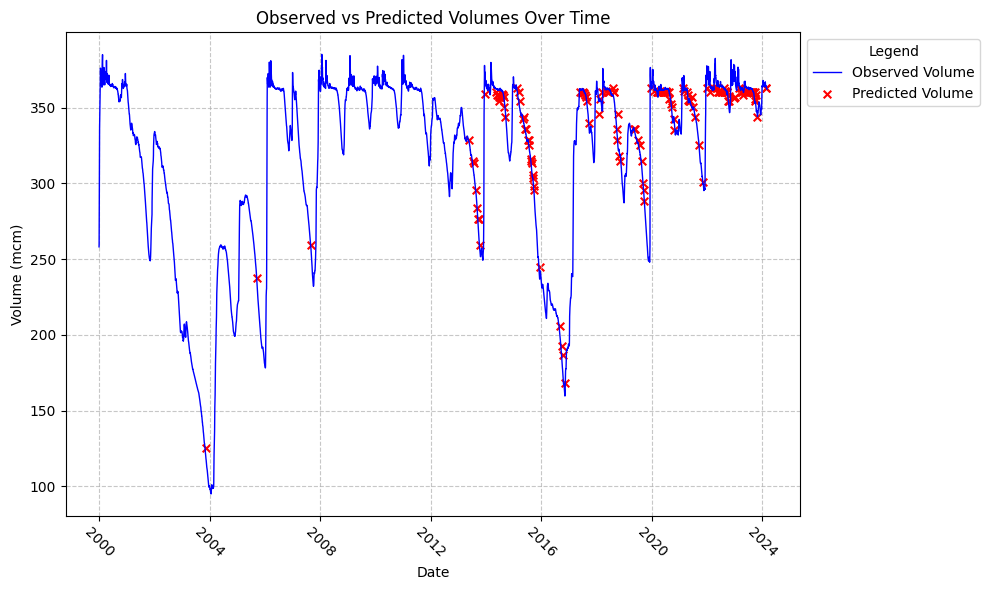

In [14]:
# Create the dataframes
observed_volumes_full_df = pd.DataFrame({
    'Date': trimmed_observed['Date'],
    'Observed Volume': trimmed_observed['Volume_mcm']
})

predicted_volumes_full_df = pd.DataFrame({
    'Date': merged_data['Date'],
    'Predicted Volume': predicted_volumes_full
})

fig, ax = plt.subplots(figsize=(10, 6))

# Plot Observed Volume
ax.plot(observed_volumes_full_df['Date'], observed_volumes_full_df['Observed Volume'], 
        label='Observed Volume', color='blue', linewidth=1)

# Plot Predicted Volume (using scatter for markers)
ax.scatter(predicted_volumes_full_df['Date'], predicted_volumes_full_df['Predicted Volume'], 
           label='Predicted Volume', color='red', marker='x', s=30)

# Set title and labels
ax.set_title('Observed vs Predicted Volumes Over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Volume (mcm)')

# Rotate x-axis labels
plt.xticks(rotation=-45)

# Move legend outside the plot
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(title='Legend', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

# Save the figure as a PNG image
# image_path = "observed_vs_predicted_volumes_matplotlib.png"
# plt.savefig(image_path, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


#### Store the results

In [15]:
output_data = pd.merge(observed_volumes_full_df, predicted_volumes_full_df, on='Date', how='left')
os.makedirs("results", exist_ok=True)
output_data.to_csv('results/volume_predictions.csv', index=False)

**References:**
- Garcia Andarcia, M., Dickens, C., Silva, P., Matheswaran, K., & Koo, J. (2024). Digital Twin for management of water resources in the Limpopo River Basin: a concept. Colombo, Sri Lanka: International Water Management Institute (IWMI). CGIAR Initiative on Digital Innovation. 4p.
- Gurusinghe, T., Muthuwatta, L., Matheswaran, K., & Dickens, C. (2024). Developing a foundational hydrological model for the Limpopo River Basin using the Soil and Water Assessment Tool Plus (SWAT+). Colombo, Sri Lanka: International Water Management Institute (IWMI). CGIAR Initiative on Digital Innovation. 14p.
- Leitão, P. C., Santos, F., Barreiros, D., Santos, H., Silva, P., Madushanka, T., Matheswaran, K., Mutuwatte, L., Vickneswaran, K., Retief, H., Dickens, C., Garcia Andarcia, M. (2024). Operational SWAT+ Model: Advancing Seasonal Forecasting in the Limpopo River Basin. Colombo, Sri Lanka:  International Water Management Institute (IWMI). CGIAR Initiative on Digital Innovation.
- Mallick, Archita & Ghosh, Surajit & De Sarkar, Kounik & Roy, Sudip. (2024). Reservoir Water Level Forecasting using Deep Learning Technique. Conference: 2024 IEEE India Geoscience and Remote Sensing Symposium

------------
## Additional information

<b> License </b> The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0).

Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

<b> Contact </b> If you need assistance, please post a question on the [DE Africa Slack channel](https://digitalearthafrica.slack.com/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).

If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

<b> Compatible datacube version </b>

## Embed into project background: 
The CGIAR Digital Innovation Initiative accelerates the transformation towards sustainable and inclusive agrifood systems by generating research-based evidence and innovative digital solutions. It is one of 32 initiatives of CGIAR, a global research partnership for a food-secure future, dedicated to transforming food, land, and water systems in a climate crisis.

### Contributors

**Hugo Retief**  
*Researcher*  
Email: [hugo@award.org.za](mailto:hugo@award.org.za)  

**Victoria Neema**  
*Earth Observation Scientist*  
Email: [victoria.neema@digitalearthafrica.org](mailto:victoria.neema@digitalearthafrica.org)  

**Kayathri Vigneswaran**  
*Junior Data Scientist*  
Email: [v.kayathri@cgiar.org](mailto:v.kayathri@cgiar.org)  


In [16]:
print(datacube.__version__)

1.8.19


**Last Tested:**

In [17]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2025-03-04'